### Analisis Emosi Pada Data Teks Twitter Berbahasa Indonesia Menggunakan Machine Learning

_Import semua libraries yang diperlukan_

In [ ]:
pip install -q demoji

     |████████████████████████████████| 42 kB 1.1 MB/s 


In [ ]:
pip install -q snscrape

In [ ]:
pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.4 MB/s 


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import csv
import gensim
import numpy as np
import seaborn as sns
import joblib
import snscrape.modules.twitter as sntwitter
import demoji
# from transformers import pipeline
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from time import time
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize

### Data Cleaning

#### Proses penghapusan beberapa _noise_ yang masih terkandung di dalam dataset

#### Memuat Dataset

In [18]:
import pandas as pd

dataset = pd.read_csv("datakorupsibaru.csv", lineterminator="\n")

dataset = dataset.rename(columns={"Isi konten": "tweet"})
dataset

,User,tweet,Date
0,HcIndependen,@tvOneNews Mau tethub bebas atas meroket teta...,2023-06-26 23:59:44+00:00
1,theforge8888,"@Okki_Sutanto @hariankompas Pusing ya, masa se...",2023-06-26 23:55:34+00:00
2,24b5cc37e61d40f,Mungkin lebih baik maksimalkan.kerja polri dan...,2023-06-26 23:54:20+00:00
3,DavinaSastro,@DavidWijaya82 Bukan cuma kasus ini aja yang b...,2023-06-26 23:53:37+00:00
4,rangkutifuat,@alisyarief @PDI_Perjuangan partai gagal membu...,2023-06-26 23:49:36+00:00
...,...,...,...
14995,reifeiza,"Keren banget deh Prabowo, Menhan baru, fokus b...",2023-06-18 02:18:00+00:00
14996,sastrotingkir,@Verraagustian_ aku kui seneng karo cak thotiq...,2023-06-18 02:17:42+00:00
14997,rikosaptr,"Keren banget deh Prabowo, Menhan baru, fokus b...",2023-06-18 02:17:35+00:00
14998,reifeiza,"Prabowo, Menhan penuh semangat: bye-bye budaya...",2023-06-18 02:17:30+00:00


_Pengecekan salah satu tweet_

In [19]:
dataset.loc[136, "tweet"]

'@SalamSantun_ Anda punya perusahaan, anak buah Anda korupsi dalam menjalankan tugasnya. Apakah otomatis Anda jadi tersangka juga?'

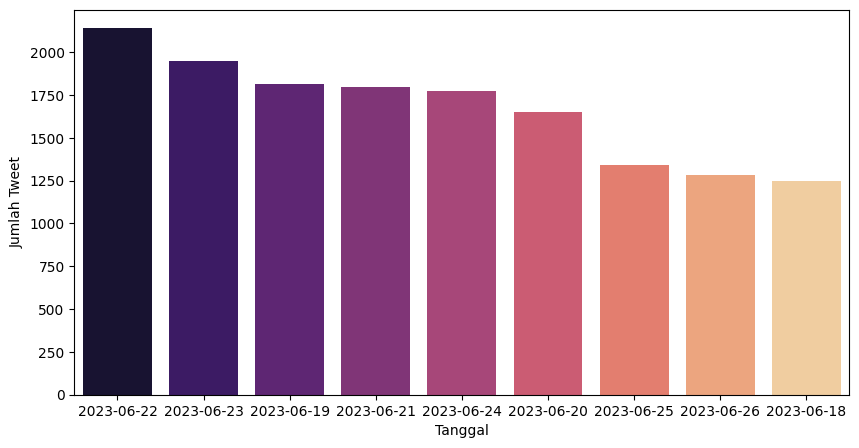

In [20]:
tweets = dataset.copy()
tweets["Date"] = pd.to_datetime(tweets["Date"], format="%Y-%m-%d %H:%M:%S%z")
tweets["Date"] = pd.to_datetime(tweets["Date"]).dt.date
number = [count for count in tweets["Date"].value_counts()]
timeline = list(tweets["Date"].value_counts().index)
figure, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=timeline, y=number, palette="magma")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Jumlah Tweet")
plt.show()

In [21]:
dataset[['tweet']]

,tweet
0,@tvOneNews Mau tethub bebas atas meroket teta...
1,"@Okki_Sutanto @hariankompas Pusing ya, masa se..."
2,Mungkin lebih baik maksimalkan.kerja polri dan...
3,@DavidWijaya82 Bukan cuma kasus ini aja yang b...
4,@alisyarief @PDI_Perjuangan partai gagal membu...
...,...
14995,"Keren banget deh Prabowo, Menhan baru, fokus b..."
14996,@Verraagustian_ aku kui seneng karo cak thotiq...
14997,"Keren banget deh Prabowo, Menhan baru, fokus b..."
14998,"Prabowo, Menhan penuh semangat: bye-bye budaya..."


In [22]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

id_stopword_dict = pd.read_csv('stopwordbahasa.csv', encoding='latin-1')
id_stopword_dict1 = id_stopword_dict.rename(columns={0: 'stop'})

alay_dict = pd.read_csv('new_kamusalay.csv', header=None, encoding='latin-1')
alay_dict = alay_dict.rename(columns={0: 'original',
                                     1: 'replacement'})
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

alay_dict2 = pd.read_csv('kamus_singkatan_deluxe.csv', sep=';',encoding='latin-1')
alay_dict2.columns = ['Column1', 'Column2']
alay_dict2 = alay_dict2.rename(columns={'Column1': 'original',
                                     'Column2': 'replacement'})
alay_dict_map2 = dict(zip(alay_dict2['original'], alay_dict2['replacement']))

# Text preprocessing functions from previous script
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def normalize_alay2(text):
    return ' '.join([alay_dict_map2[word] if word in alay_dict_map2 else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in id_stopword_dict.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

# Modified clean_text function that calls preprocessing functions from previous script
def preprocess(text):
    text = remove_unnecessary_char(text) # Remove unnecessary characters
    text = lowercase(text) # Convert text to lowercase
    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_alay2(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    # tokens = tokenize(text)
    return text

# Apply the clean_text function to the 'Isi konten' column in datakorupsibaru
dataset['preprocessed'] = dataset['tweet'].apply(preprocess)

# Remove duplicates
dataset.drop_duplicates(subset=['preprocessed'], inplace=True)

dataset

,User,tweet,Date,preprocessed
0,HcIndependen,@tvOneNews Mau tethub bebas atas meroket teta...,2023-06-26 23:59:44+00:00,tethub bebas meroket utang utang utang utang u...
1,theforge8888,"@Okki_Sutanto @hariankompas Pusing ya, masa se...",2023-06-26 23:55:34+00:00,pusing ya muncul berulang ulang ada salah 1 ko...
2,24b5cc37e61d40f,Mungkin lebih baik maksimalkan.kerja polri dan...,2023-06-26 23:54:20+00:00,maksimalkan kerja kepolisian republik indonesi...
3,DavinaSastro,@DavidWijaya82 Bukan cuma kasus ini aja yang b...,2023-06-26 23:53:37+00:00,menjerat sih penyebar hoaks korupsi payment gate
4,rangkutifuat,@alisyarief @PDI_Perjuangan partai gagal membu...,2023-06-26 23:49:36+00:00,ai gagal membuktikan indonesia berkuasa pencap...
...,...,...,...,...
14991,reifeiza,"Denger-denger nih, Prabowo, Menhan baru kita, ...",2023-06-18 02:19:00+00:00,dengar dengar nih prabowo menhan niat deh hapu...
14993,reifeiza,"Gak main-main nih Prabowo, Menhan kita, ngasih...",2023-06-18 02:18:30+00:00,main main nih prabowo menhan janji ada budaya ...
14995,reifeiza,"Keren banget deh Prabowo, Menhan baru, fokus b...",2023-06-18 02:18:00+00:00,keren deh prabowo menhan fokus hapus budaya ko...
14996,sastrotingkir,@Verraagustian_ aku kui seneng karo cak thotiq...,2023-06-18 02:17:42+00:00,senang cak thotiq mugo mugo kesandung korupsi


_Pengecekan jumlah tweet dari masing-masing label_

In [6]:
print(dataset.label.value_counts())

AttributeError: 'DataFrame' object has no attribute 'label'

#### Visualisasi Dataset

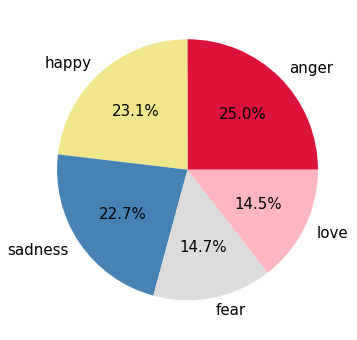

In [ ]:
figure, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in dataset.label.value_counts()]
labels = list(dataset.label.value_counts().index)
colors = ("crimson", "khaki", "steelblue", "gainsboro", "lightpink")
ax.pie(x=sizes, labels=labels, autopct="%1.1f%%", colors=colors, textprops={"fontsize": 15})
plt.show()

#### Text Preprocessing

##### 1. Removal of Sensitive Information

_Menghapus mentions, url, dan hashtags yang ada pada setiap tweet_

In [ ]:
def removal_of_sensitive_info(text):
    text = text.replace("[USERNAME]", " ")
    text = text.replace("[URL]", " ")
    text = text.replace("[SENSITIVE-NO]", " ")
    text = re.sub("#[A-Za-z0-9]+", " ", text)
    return text
dataset["preprocessed"] = dataset.tweet.apply(lambda text: removal_of_sensitive_info(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...","Sharing pengalaman aja, kemarin jam 18.00 bata..."
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...","Tahukah kamu, bahwa saat itu papa memejamkan m..."
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...","5. masa depannya nggak jelas. lha iya, gimana ..."
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu beneran ada mahasiswa Teknik UI nembak ...


_Pengecekan salah satu tweet_

In [ ]:
dataset.loc[136, "preprocessed"]

'Udah semingguan ga ada kabar wkwkwkwk Akunya sibuk ngurus rapot sama ijazah anak :"( Terus ga nanya kabarnya dia juga selama seminggu Sahabat macam apa kamu :"('

##### 2. Transformation of Emoticons

_Mengubah emoticons yang ada pada setiap tweet menjadi bentuk kata yang bersesuaian_

In [ ]:
def transform_emoticons(text):
    text = text.replace("<3", "<love>")
    text = text.replace(":p", "<mengejek>")
    text = text.replace(":P", "<mengejek>")
    text = text.replace(":v", "<melucu>")
    text = text.replace(":V", "<melucu>")
    text = text.replace(":d", "<tertawa>")
    text = text.replace(":D", "<tertawa>")
    text = text.replace(":-D", "<tertawa>")
    text = text.replace(":o", "<terkejut>")
    text = text.replace(":O", "<terkejut>")
    text = text.replace("xD", "<tertawa terbahak bahak>")
    text = text.replace("XD", "<tertawa terbahak bahak>")
    text = text.replace(":*", "<mencium>")
    text = text.replace(":3", "<malu malu kucing>")
    text = text.replace("-__-", "<wajah datar>")
    text = text.replace("-_-", "<wajah datar>")
    text = text.replace(":|", "<wajah datar>")
    text = text.replace(":\\", "<terganggu>")
    text = text.replace(":/", "<terganggu>")
    text = text.replace(":))", "<senyum>")
    text = text.replace(":)", "<senyum>")
    text = text.replace(":-))", "<senyum>")
    text = text.replace(":-)", "<senyum>")
    text = text.replace("^^", "<senyum>")
    text = text.replace("^_^", "<senyum>")
    text = text.replace(";))", "<senyum berkedip>")
    text = text.replace(";)", "<senyum berkedip>")
    text = text.replace(":((", "<sedih>")
    text = text.replace(":(", "<sedih>")
    text = text.replace(":-((", "<sedih>")
    text = text.replace(":-(", "<sedih>")
    text = text.replace(":'((", "<menangis sedih>")
    text = text.replace(":'(", "<menangis sedih>")
    text = text.replace(":'))", "<menangis bahagia>")
    text = text.replace(":')", "<menangis bahagia>")
    text = text.replace(":'", "<menangis sedih>")
    text = text.replace(":’((", "<menangis sedih>")
    text = text.replace(":’(", "<menangis sedih>")
    text = text.replace(":’))", "<menangis bahagia>")
    text = text.replace(":’)", "<menangis bahagia>")
    text = text.replace(":’", "<menangis sedih>")
    text = text.replace(":\"((", "<menangis sedih>")
    text = text.replace(":\"(", "<menangis sedih>")
    text = text.replace(":\"))", "<menangis bahagia>")
    text = text.replace(":\")", "<menangis bahagia>")
    text = text.replace(":\"", "<menangis sedih>")
    text = text.replace(":\"D", "<menangis bahagia>")
    text = text.replace("TT", "<menangis sedih>")
    return text
dataset.preprocessed = dataset.preprocessed.apply(lambda text: transform_emoticons(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...","Sharing pengalaman aja, kemarin jam 18.00 bata..."
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...","Tahukah kamu, bahwa saat itu papa memejamkan m..."
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...","5. masa depannya nggak jelas. lha iya, gimana ..."
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu beneran ada mahasiswa Teknik UI nembak ...


_Pengecekan salah satu tweet_

In [1]:
dataset.loc[136, "preprocessed"]

NameError: ignored

##### 3. Removal of Punctuations

_Menghapus tanda baca yang termuat dalam setiap tweet_

In [ ]:
def remove_punctuations(text):
    text = re.sub("[" + string.punctuation + "]", " ", text)
    text = text.replace("“", " ")
    text = text.replace("”", " ")
    text = text.replace("…", " ")
    return text
dataset.preprocessed = dataset.preprocessed.apply(lambda text: remove_punctuations(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",Soal jln Jatibaru polisi tdk bs GERTAK gubernu...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",Sesama cewe lho kayaknya harusnya bisa lebi...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,Kepingin gudeg mbarek Bu hj Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",Jln Jatibaru bagian dari wilayah Tn Abang Peng...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",Sharing pengalaman aja kemarin jam 18 00 bata...
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",Tahukah kamu bahwa saat itu papa memejamkan m...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",5 masa depannya nggak jelas lha iya gimana ...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu beneran ada mahasiswa Teknik UI nembak ...


_Pengecekan salah satu tweet_

In [ ]:
dataset.loc[136, "preprocessed"]

'Udah semingguan ga ada kabar wkwkwkwk Akunya sibuk ngurus rapot sama ijazah anak  menangis sedih  Terus ga nanya kabarnya dia juga selama seminggu Sahabat macam apa kamu  menangis sedih '

##### 4. Lower Casing

_Mengubah kata pada setiap tweet menjadi lowercase (huruf kecil)_

In [ ]:
def lower_casing(text):
    return text.lower()
dataset.preprocessed = dataset.preprocessed.apply(lambda text: lower_casing(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jln jatibaru polisi tdk bs gertak gubernu...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewe lho kayaknya harusnya bisa lebi...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jln jatibaru bagian dari wilayah tn abang peng...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam 18 00 bata...
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahukah kamu bahwa saat itu papa memejamkan m...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulitnya menetapkan calon wapresnya jokowi di ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",5 masa depannya nggak jelas lha iya gimana ...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu beneran ada mahasiswa teknik ui nembak ...


_Pengecekan salah satu tweet_

In [ ]:
dataset.loc[136, "preprocessed"]

'udah semingguan ga ada kabar wkwkwkwk akunya sibuk ngurus rapot sama ijazah anak  menangis sedih  terus ga nanya kabarnya dia juga selama seminggu sahabat macam apa kamu  menangis sedih '

##### 5. Transformation of Slang Words

_Melakukan pengubahan terhadap kata-kata yang tidak formal_

In [ ]:
slang_dictionary = pd.read_csv("new_kamusalay.csv", encoding='latin-1', header=None)
slang_map = dict(zip(slang_dictionary[0], slang_dictionary[1]))
def transform_slang(text):
    return ' '.join([slang_map[w] if w in slang_map else w for w in text.split(' ')])
dataset.preprocessed = dataset.preprocessed.apply(lambda text: transform_slang(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jalan jatibaru polisi tidak bisa gertak g...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewek lo kayaknya harusnya bisa lebi...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,ingin gudeg mbarek bu hj amat foto dari googl...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jalan jatibaru bagian dari wilayah tn abang pe...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman saja kemarin jam 18 00 bat...
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahukah kamu bahwa saat itu papa memejamkan m...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulitnya menetapkan calon wakil presidennya jo...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",5 masa depannya enggak jelas lah iya bagaim...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu benaran ada mahasiswa teknik oi menemba...


_Pengecekan salah satu tweet_

In [ ]:
dataset.loc[136, "preprocessed"]

'sudah semingguan tidak ada kabar wkwk akunya sibuk mengurus rapot sama ijazah anak  menangis sedih  terus tidak bertanya kabarnya dia juga selama seminggu sahabat macam apa kamu  menangis sedih '

##### 6. Transformation of Abbreviations

_Normalisasi singkatan kata pada setiap tweet berdasarkan kamus singkatan kata_

In [ ]:
abbreviations_dictionary = pd.read_csv("kamus_singkatan_deluxe.csv", delimiter=';', header=None)
abbreviations_map = dict(zip(abbreviations_dictionary[0], abbreviations_dictionary[1]))
def transform_abbreviate(text):
    return ' '.join([abbreviations_map[w] if w in abbreviations_map else w for w in text.split(' ')])
dataset.preprocessed = dataset.preprocessed.apply(lambda text: transform_abbreviate(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jalan jatibaru polisi tidak bisa gertak g...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewek kamu kayaknya harusnya bisa le...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,ingin gudeg mbarek bu hj amat foto dari googl...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jalan jatibaru bagian dari wilayah tn abang pe...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman saja kemarin jam 18 00 bat...
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahukah kamu bahwa saat itu papa memejamkan m...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulitnya menetapkan calon wakil presidennya jo...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",5 masa depannya tidak jelas lah iya bagaim...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu benaran ada mahasiswa teknik oi menemba...


_Pengecekan salah satu tweet_

In [ ]:
dataset.loc[136, "preprocessed"]

'sudah semingguan tidak ada kabar wkwk akunya sibuk mengurus rapot sama ijazah anak  menangis sedih  terus tidak bertanya kabarnya dia juga selama seminggu sahabat macam apa kamu  menangis sedih '

##### 7. Removal of Numbers

_Menghapus angka yang ada pada setiap tweet_

In [ ]:
def remove_numbers(text):
    text = re.sub("[0-9]+", " ", text)
    return text
dataset.preprocessed = dataset.preprocessed.apply(lambda text: remove_numbers(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jalan jatibaru polisi tidak bisa gertak g...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewek kamu kayaknya harusnya bisa le...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,ingin gudeg mbarek bu hj amat foto dari googl...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jalan jatibaru bagian dari wilayah tn abang pe...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman saja kemarin jam batal...
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahukah kamu bahwa saat itu papa memejamkan m...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulitnya menetapkan calon wakil presidennya jo...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",masa depannya tidak jelas lah iya bagaim...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu benaran ada mahasiswa teknik oi menemba...


_Pengecekan salah satu tweet_

In [ ]:
dataset.loc[136, "preprocessed"]

'sudah semingguan tidak ada kabar wkwk akunya sibuk mengurus rapot sama ijazah anak  menangis sedih  terus tidak bertanya kabarnya dia juga selama seminggu sahabat macam apa kamu  menangis sedih '

##### 8. Removal of Multiple Whitespaces

_Menghapus spasi yang berlebih_

In [ ]:
def remove_multi_whitespaces(text):
    text = re.sub(" +", " ", text).strip(" ")
    return text
dataset.preprocessed = dataset.preprocessed.apply(lambda text: remove_multi_whitespaces(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jalan jatibaru polisi tidak bisa gertak g...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewek kamu kayaknya harusnya bisa lebih...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,ingin gudeg mbarek bu hj amat foto dari google...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jalan jatibaru bagian dari wilayah tn abang pe...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman saja kemarin jam batalin ti...
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahukah kamu bahwa saat itu papa memejamkan ma...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulitnya menetapkan calon wakil presidennya jo...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",masa depannya tidak jelas lah iya bagaimana ma...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu benaran ada mahasiswa teknik oi menembak ...


_Pengecekan salah satu tweet_

In [ ]:
dataset.loc[136, "preprocessed"]

'sudah semingguan tidak ada kabar wkwk akunya sibuk mengurus rapot sama ijazah anak menangis sedih terus tidak bertanya kabarnya dia juga selama seminggu sahabat macam apa kamu menangis sedih'

##### 9. Removal of Single Letters

_Menghapus single letter yang ada pada setiap tweet_

In [ ]:
def remove_single_letters(text):
    return " ".join([w for w in text.split() if len(w) > 1])
dataset.preprocessed = dataset.preprocessed.apply(lambda text: remove_single_letters(text))
dataset

,label,tweet,preprocessed
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jalan jatibaru polisi tidak bisa gertak g...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewek kamu kayaknya harusnya bisa lebih...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,ingin gudeg mbarek bu hj amat foto dari google...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jalan jatibaru bagian dari wilayah tn abang pe...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman saja kemarin jam batalin ti...
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahukah kamu bahwa saat itu papa memejamkan ma...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulitnya menetapkan calon wakil presidennya jo...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",masa depannya tidak jelas lah iya bagaimana ma...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,dulu benaran ada mahasiswa teknik oi menembak ...


_Pengecekan salah satu tweet_

In [ ]:
dataset.loc[136, "preprocessed"]

'sudah semingguan tidak ada kabar wkwk akunya sibuk mengurus rapot sama ijazah anak menangis sedih terus tidak bertanya kabarnya dia juga selama seminggu sahabat macam apa kamu menangis sedih'

##### 10. Removal of Stopwords

_Menghapus beberapa kosakata yang tidak memberikan informasi penting (stopwords)_

In [ ]:
def remove_stopwords(text):
    stopwords_list = set(stopwords.words("indonesian"))
    return [w for w in text.split() if w not in stopwords_list]
dataset.preprocessed = dataset.preprocessed.apply(lambda text: remove_stopwords(text))
dataset.preprocessed = [(' ').join(w) for w in dataset.preprocessed]
dataset

LookupError: ignored

_Pengecekan salah satu tweet_

In [23]:
dataset.loc[136, "preprocessed"]

'perusahaan anak buah korupsi menjalankan tugasnya otomatis tersangka'

#### Menyimpan Hasil Preprocessing

_Menyimpan hasil preprocessing ke dalam file baru berformat .csv_

In [24]:
dataset.drop(["tweet"], axis=1, inplace=True)
columns = {"preprocessed": "tweet"}
dataset.rename(columns=columns, inplace=True)
dataset.to_csv("preprocessed_dataset.csv", index=False, header=True)
dataset

,User,Date,tweet
0,HcIndependen,2023-06-26 23:59:44+00:00,tethub bebas meroket utang utang utang utang u...
1,theforge8888,2023-06-26 23:55:34+00:00,pusing ya muncul berulang ulang ada salah 1 ko...
2,24b5cc37e61d40f,2023-06-26 23:54:20+00:00,maksimalkan kerja kepolisian republik indonesi...
3,DavinaSastro,2023-06-26 23:53:37+00:00,menjerat sih penyebar hoaks korupsi payment gate
4,rangkutifuat,2023-06-26 23:49:36+00:00,ai gagal membuktikan indonesia berkuasa pencap...
...,...,...,...
14991,reifeiza,2023-06-18 02:19:00+00:00,dengar dengar nih prabowo menhan niat deh hapu...
14993,reifeiza,2023-06-18 02:18:30+00:00,main main nih prabowo menhan janji ada budaya ...
14995,reifeiza,2023-06-18 02:18:00+00:00,keren deh prabowo menhan fokus hapus budaya ko...
14996,sastrotingkir,2023-06-18 02:17:42+00:00,senang cak thotiq mugo mugo kesandung korupsi


### Model Development

#### Proses pembuatan model _Machine Learning_

#### Memuat Hasil Preprocessing

In [25]:
preprocessed_dataset = pd.read_csv("preprocessed_dataset.csv")
preprocessed_dataset['tweet'] = preprocessed_dataset['tweet'].astype(str)
preprocessed_dataset

,User,Date,tweet
0,HcIndependen,2023-06-26 23:59:44+00:00,tethub bebas meroket utang utang utang utang u...
1,theforge8888,2023-06-26 23:55:34+00:00,pusing ya muncul berulang ulang ada salah 1 ko...
2,24b5cc37e61d40f,2023-06-26 23:54:20+00:00,maksimalkan kerja kepolisian republik indonesi...
3,DavinaSastro,2023-06-26 23:53:37+00:00,menjerat sih penyebar hoaks korupsi payment gate
4,rangkutifuat,2023-06-26 23:49:36+00:00,ai gagal membuktikan indonesia berkuasa pencap...
...,...,...,...
14030,reifeiza,2023-06-18 02:19:00+00:00,dengar dengar nih prabowo menhan niat deh hapu...
14031,reifeiza,2023-06-18 02:18:30+00:00,main main nih prabowo menhan janji ada budaya ...
14032,reifeiza,2023-06-18 02:18:00+00:00,keren deh prabowo menhan fokus hapus budaya ko...
14033,sastrotingkir,2023-06-18 02:17:42+00:00,senang cak thotiq mugo mugo kesandung korupsi


#### Mencari Representasi Fitur

_Memuat model pre-trained FastText_

In [26]:
fasttext = gensim.models.fasttext.load_facebook_model("C:/Users/rizky/Downloads/Gemastik tahun lalu/Gemastik/Pre-trained Word Embedding/Fastext_model_tweet.bin")
print("Ada %s vektor kata yang ditemukan dalam model FastText" % len(fasttext.wv))

Ada 69465 vektor kata yang ditemukan dalam model FastText


_Merepresentasikan setiap tweet ke dalam vektor bilangan real_

In [39]:
vectors = []
for text in preprocessed_dataset.tweet.values:
    word_embedding = []
    for word in text.split(" "):
        try:
            word_vec = fasttext.wv[word]
            word_embedding.append(word_vec)
        except:
            pass
    word_embedding = np.array(word_embedding)
    embeddings = np.mean(word_embedding, axis=0)
    vectors.append(embeddings)
vectors = np.array(vectors)
print("Dimensi dari fitur yang digunakan yaitu", (vectors.shape))

Dimensi dari fitur yang digunakan yaitu (14035, 100)


In [40]:
import pandas as pd
from textblob import TextBlob

abusive_df = pd.read_csv('abusivebaru.csv')
Kategori_korupsi = pd.read_excel('kategori_korupsi.xlsx')

sentiments = []
gol_korupsi = []

for tweet in preprocessed_dataset['tweet']:
    if pd.isna(tweet):
        sentiments.append('NaN')
        continue
    if isinstance(tweet, str):
        if any(str(word) in tweet for word in list(abusive_df['ABUSIVE'])):
            sentiments.append('negatif')
            if any(str(word) in tweet for word in list(Kategori_korupsi['Kesehatan'])):
                gol_korupsi.append('Kesehatan')
            elif any(str(word) in tweet for word in list(Kategori_korupsi['Teknologi'])):
                gol_korupsi.append('teknologi')
            elif any(str(word) in tweet for word in list(Kategori_korupsi['Infrastruktur'])):
                gol_korupsi.append('infrastruktur')
            elif any(str(word) in tweet for word in list(Kategori_korupsi['Pendidikan'])):
                gol_korupsi.append('Pendidikan')
            elif any(str(word) in tweet for word in list(Kategori_korupsi['Polisi'])):
                gol_korupsi.append('Polisi')
            elif any(str(word) in tweet for word in list(Kategori_korupsi['Ekonomi'])):
                gol_korupsi.append('Ekonomi')
            elif any(str(word) in tweet for word in list(Kategori_korupsi['Sosial'])):
                gol_korupsi.append('Sosial')
            elif any(str(word) in tweet for word in list(Kategori_korupsi['Hukum'])):
                gol_korupsi.append('Hukum')
        else:
            analysis = TextBlob(tweet)
            if analysis.sentiment.polarity > 0:
                sentiments.append('positif')
            else:
                sentiments.append('netral')
    else:
        sentiments.append('NaN')

preprocessed_dataset['label'] = sentiments
preprocessed_dataset['Kategori Korupsi'] = gol_korupsi

preprocessed_dataset = preprocessed_dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)
preprocessed_dataset = preprocessed_dataset.dropna()

preprocessed_dataset

ValueError: Length of values (7477) does not match length of index (14035)

In [9]:
preprocessed_dataset.to_csv("preprocessed_dataset.csv", index=False, header=True)

_Visualisasi scatter plot dari fitur yang dipakai_

In [1]:
X = vectors
Y = np.array(preprocessed_dataset.Label)
figure, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, ax=ax, palette="Spectral")
plt.show()

NameError: name 'vectors' is not defined

#### Membagi Dataset

_Dataset dibagi menjadi 90% train data dan 10% test data_

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)
print("Jumlah dari train data adalah", len(X_train))
print("\nSedangkan jumlah dari test data yaitu", len(X_test))

Jumlah dari train data adalah 3960

Sedangkan jumlah dari test data yaitu 441


#### Membangun Model K-Nearest Neighbors (KNN)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

_Melatih model KNN menggunakan train data_

In [ ]:
knn.fit(X_train, Y_train)
filename = "KNN.sav"
joblib.dump(knn, filename)

['KNN.sav']

_Menguji model KNN menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("KNN.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 52.83%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.53      0.71      0.61       122
        fear       0.40      0.32      0.35        66
       happy       0.53      0.54      0.54       106
        love       0.68      0.72      0.70        54
     sadness       0.48      0.31      0.38        93

    accuracy                           0.53       441
   macro avg       0.52      0.52      0.52       441
weighted avg       0.52      0.53      0.52       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.09 detik.


_Menampilkan visualisasi dari confusion matriksnya_

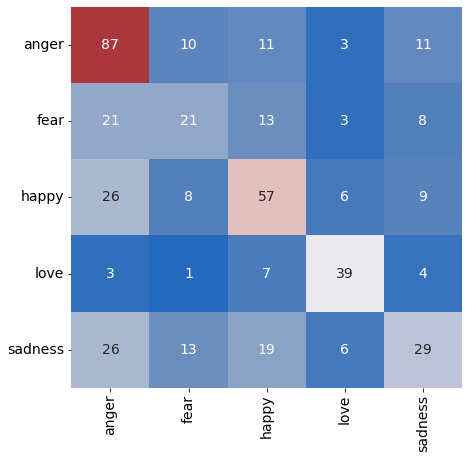

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

#### Membangun Model Random Forest

In [ ]:
random_forest = RandomForestClassifier()

_Melatih model Random Forest menggunakan train data_

In [ ]:
random_forest.fit(X_train, Y_train)
filename = "RF.sav"
joblib.dump(random_forest, filename)

['RF.sav']

_Menguji model Random Forest menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("RF.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 59.64%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.61      0.78      0.68       122
        fear       0.82      0.42      0.56        66
       happy       0.58      0.63      0.61       106
        love       0.73      0.65      0.69        54
     sadness       0.43      0.41      0.42        93

    accuracy                           0.60       441
   macro avg       0.64      0.58      0.59       441
weighted avg       0.61      0.60      0.59       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.13 detik.


_Menampilkan visualisasi dari confusion matriksnya_

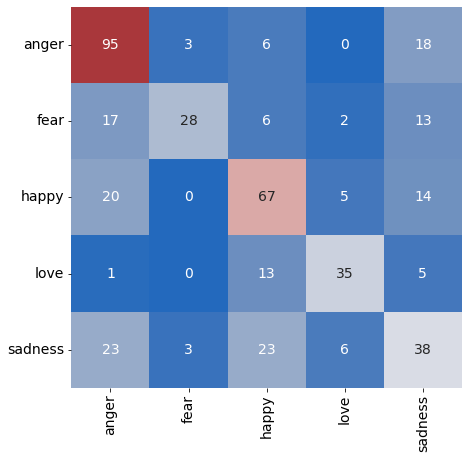

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

#### Membangun Model Support Vector Machine (SVM)

##### Fungsi Kernel Linear

In [ ]:
linear_svm = SVC(kernel="linear")

_Melatih model SVM menggunakan train data_

In [ ]:
linear_svm.fit(X_train, Y_train)
filename = "SVMlinear.sav"
joblib.dump(linear_svm, filename)

['SVMlinear.sav']

_Menguji model SVM menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("SVMlinear.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 60.54%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.64      0.80      0.71       122
        fear       0.74      0.47      0.57        66
       happy       0.60      0.58      0.59       106
        love       0.75      0.74      0.75        54
     sadness       0.41      0.41      0.41        93

    accuracy                           0.61       441
   macro avg       0.63      0.60      0.61       441
weighted avg       0.61      0.61      0.60       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.09 detik.


_Menampilkan visualisasi dari confusion matriksnya_

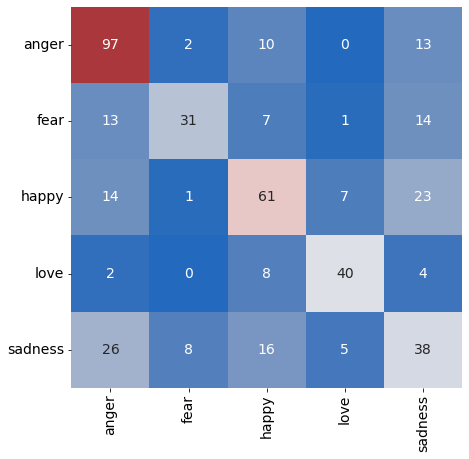

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

##### Fungsi Kernel RBF

In [ ]:
rbf_svm = SVC(kernel="rbf")

_Melatih model SVM menggunakan train data_

In [ ]:
rbf_svm.fit(X_train, Y_train)
filename = "SVMRBF.sav"
joblib.dump(rbf_svm, filename)

['SVMRBF.sav']

_Menguji model SVM menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("SVMRBF.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 61.68%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.64      0.79      0.71       122
        fear       0.74      0.48      0.59        66
       happy       0.63      0.62      0.63       106
        love       0.76      0.72      0.74        54
     sadness       0.41      0.42      0.42        93

    accuracy                           0.62       441
   macro avg       0.64      0.61      0.62       441
weighted avg       0.62      0.62      0.61       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.27 detik.


_Menampilkan visualisasi dari confusion matriksnya_

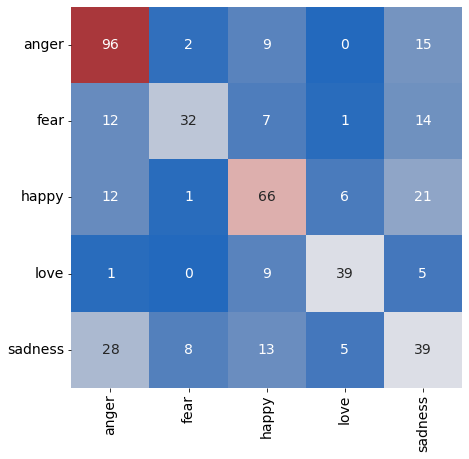

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

##### Fungsi Kernel Polynomial

In [ ]:
poly_svm = SVC(kernel="poly", degree=3)

_Melatih model SVM menggunakan train data_

In [ ]:
poly_svm.fit(X_train, Y_train)
filename = "SVMPolynomial.sav"
joblib.dump(poly_svm, filename)

['SVMPolynomial.sav']

_Menguji model SVM menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("SVMPolynomial.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 62.81%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.65      0.76      0.70       122
        fear       0.75      0.50      0.60        66
       happy       0.64      0.65      0.65       106
        love       0.78      0.74      0.76        54
     sadness       0.44      0.45      0.44        93

    accuracy                           0.63       441
   macro avg       0.65      0.62      0.63       441
weighted avg       0.64      0.63      0.63       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.08 detik.


_Menampilkan visualisasi dari confusion matriksnya_

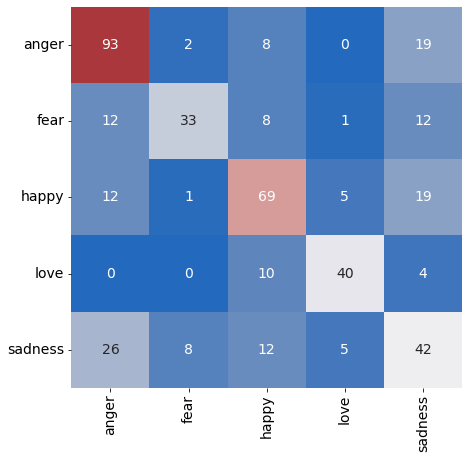

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

#### Proses pembuatan model _Machine Learning_ dengan mengaplikasikan PCA

#### Ekstraksi Fitur

_Mengaplikasikan PCA untuk mereduksi dimensi dari fitur yang dipakai_

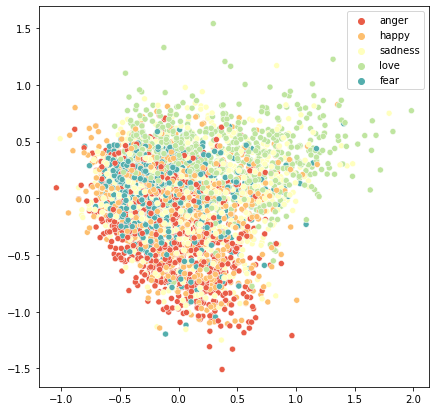

In [ ]:
pca = PCA(n_components=80)
X_PCA = pca.fit_transform(X)
figure, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], hue=Y, ax=ax, palette="Spectral")
plt.show()

_Mengecek proporsi variansi dari principal components yang dipilih_

In [ ]:
print("Principal components yang dipilih memuat %.2f%% dari karakteristik data" % (sum(pca.explained_variance_ratio_)*100))

Principal components yang dipilih memuat 94.24% dari karakteristik data


#### Membagi Dataset

_Dataset dibagi menjadi 90% train data dan 10% test data_

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_PCA, Y, test_size=0.1)
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)
print("Jumlah dari train data adalah", len(X_train))
print("\nSedangkan jumlah dari test data yaitu", len(X_test))

Jumlah dari train data adalah 3960

Sedangkan jumlah dari test data yaitu 441


#### Membangun Model K-Nearest Neighbors (KNN)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

_Melatih model KNN menggunakan train data_

In [ ]:
knn.fit(X_train, Y_train)
filename = "KNN_model.sav"
joblib.dump(knn, filename)

['KNN_model.sav']

_Menguji model KNN menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("KNN_model.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 58.50%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.60      0.85      0.71       106
        fear       0.66      0.50      0.57        70
       happy       0.61      0.54      0.57       114
        love       0.58      0.72      0.65        58
     sadness       0.45      0.32      0.38        93

    accuracy                           0.59       441
   macro avg       0.58      0.59      0.57       441
weighted avg       0.58      0.59      0.57       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.07 detik.


_Menampilkan visualisasi dari confusion matriksnya_

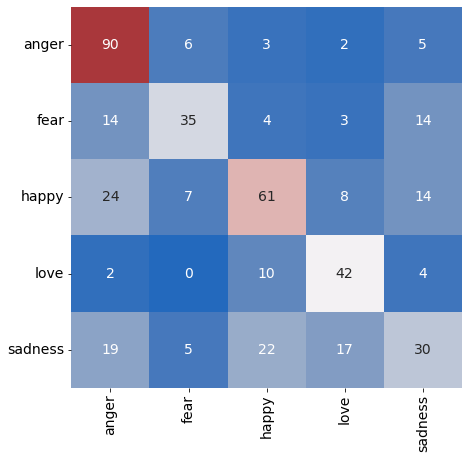

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

#### Membangun Model Random Forest

In [ ]:
random_forest = RandomForestClassifier()

_Melatih model Random Forest menggunakan train data_

In [ ]:
random_forest.fit(X_train, Y_train)
filename = "RF_model.sav"
joblib.dump(random_forest, filename)

['RF_model.sav']

_Menguji model Random Forest menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("RF_model.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 62.36%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.64      0.78      0.71       123
        fear       0.82      0.42      0.56        64
       happy       0.52      0.70      0.60        90
        love       0.83      0.56      0.67        72
     sadness       0.54      0.53      0.54        92

    accuracy                           0.62       441
   macro avg       0.67      0.60      0.61       441
weighted avg       0.65      0.62      0.62       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.08 detik.


_Menampilkan visualisasi dari confusion matriksnya_

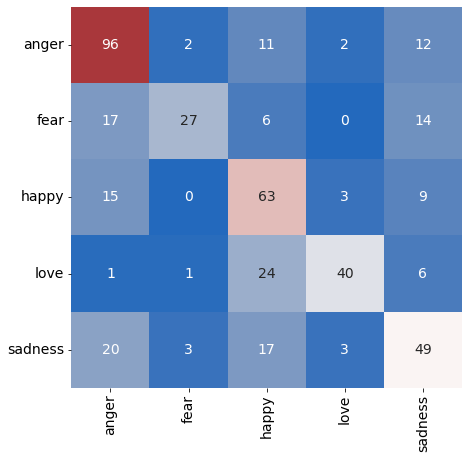

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

#### Membangun Model Support Vector Machine (SVM)

##### Fungsi Kernel Linear

In [ ]:
linear_svm = SVC(kernel="linear")

_Melatih model SVM menggunakan train data_

In [ ]:
linear_svm.fit(X_train, Y_train)
filename = "SVMlinear_model.sav"
joblib.dump(linear_svm, filename)

['SVMlinear_model.sav']

_Menguji model SVM menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("SVMlinear_model.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 65.99%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.65      0.86      0.74       106
        fear       0.80      0.57      0.67        70
       happy       0.66      0.61      0.64       114
        love       0.82      0.79      0.81        58
     sadness       0.49      0.47      0.48        93

    accuracy                           0.66       441
   macro avg       0.69      0.66      0.67       441
weighted avg       0.67      0.66      0.66       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.06 detik.


_Menampilkan visualisasi dari confusion matriksnya_

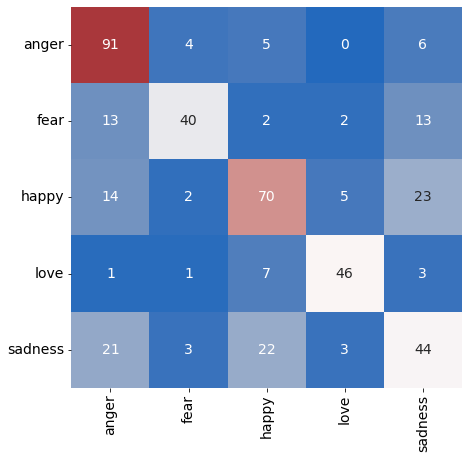

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

##### Fungsi Kernel RBF

In [ ]:
rbf_svm = SVC(kernel="rbf")

_Melatih model SVM menggunakan train data_

In [ ]:
rbf_svm.fit(X_train, Y_train)
filename = "SVMRBF_model.sav"
joblib.dump(rbf_svm, filename)

['SVMRBF_model.sav']

_Menguji model SVM menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("SVMRBF_model.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 70.52%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.68      0.91      0.78       106
        fear       0.89      0.59      0.71        70
       happy       0.74      0.68      0.71       114
        love       0.90      0.74      0.81        58
     sadness       0.52      0.57      0.55        93

    accuracy                           0.71       441
   macro avg       0.75      0.70      0.71       441
weighted avg       0.73      0.71      0.71       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.34 detik.


_Menampilkan visualisasi dari confusion matriksnya_

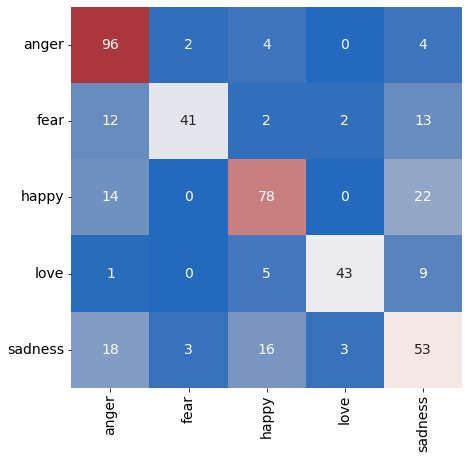

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

##### Fungsi Kernel Polynomial

In [ ]:
poly_svm = SVC(kernel="poly", degree=3)

_Melatih model SVM menggunakan train data_

In [ ]:
poly_svm.fit(X_train, Y_train)
filename = "SVMPolynomial_model.sav"
joblib.dump(poly_svm, filename)

['SVMPolynomial_model.sav']

_Menguji model SVM menggunakan test data_

In [ ]:
start = time()
loaded_model = joblib.load("SVMPolynomial_model.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

Akurasi yang dihasilkan pada proses pengujian adalah 67.80%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.66      0.90      0.76       106
        fear       0.83      0.50      0.62        70
       happy       0.73      0.64      0.68       114
        love       0.86      0.74      0.80        58
     sadness       0.50      0.57      0.53        93

    accuracy                           0.68       441
   macro avg       0.72      0.67      0.68       441
weighted avg       0.70      0.68      0.68       441

Lama waktu yang dibutuhkan untuk memproses yaitu 0.09 detik.


_Menampilkan visualisasi dari confusion matriksnya_

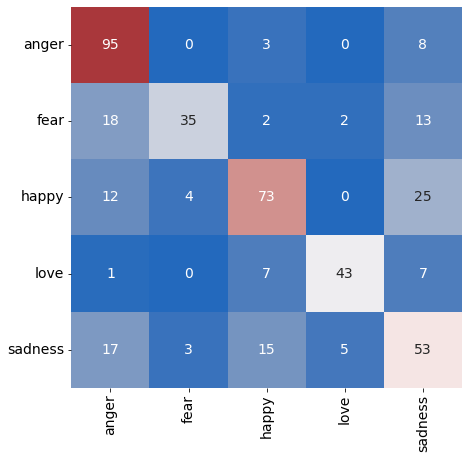

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="g", annot_kws={"size": 14}, cmap="vlag", cbar=False)
ax.set_xticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=90)
ax.set_yticklabels(["anger", "fear", "happy", "love", "sadness"], fontsize="14", rotation=0)
plt.show()

### Classification

#### Twitter Data Mining

_Menentukan keyword yang ingin dicari_

In [ ]:
keyword = str(input("Keyword: "))
while not keyword:
    keyword = str(input("Keyword: "))

KeyboardInterrupt: ignored

_Menentukan banyaknya tweet yang dicari_

In [ ]:
num_tweets = ""
while num_tweets is not int:
    try:
        num_tweets = int(input("Jumlah tweet: "))
        if num_tweets > 120:
            break
        else:
            continue
    except ValueError:
        continue

_Melakukan scraping data Twitter_

In [ ]:
twitter_data_list = []
for i, tweet in enumerate(sntwitter.TwitterSearchScraper(keyword + " lang:id -filter:replies").get_items()):
    if i > num_tweets:
        break
    twitter_data_list.append([tweet.user.username, tweet.content])

_Memuat hasil scraping ke dalam data frame_

In [ ]:
file_loc = "galau1.csv"
twitter_data_list = pd.read_csv(file_loc, lineterminator="\n")
twitter_data_list

,tweet id,username,tweet,created at\r\r
0,1575998572088082433,aectzhe,"udah ahh, ngga mau galau lagi",2022-09-30\r\r
1,1575998294333231106,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,2022-09-30\r\r
2,1575997769537695745,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,2022-09-30\r\r
3,1575997701539233792,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,2022-09-30\r\r
4,1575997653124521984,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",2022-09-30\r\r
...,...,...,...,...
4995,1575351560103567360,kretascpt,story galau gitu lagi ngincer sp si bestie,2022-09-29\r\r
4996,1575351542365814784,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",2022-09-29\r\r
4997,1575351443992633345,Pengnbahagiaa,Galau = lagu rock 🤝,2022-09-29\r\r
4998,1575350922741424128,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...",2022-09-29\r\r


In [ ]:
columns = ["username", "tweet"]
twitter_data = pd.DataFrame(twitter_data_list, columns=columns)
twitter_data


,username,tweet
0,aectzhe,"udah ahh, ngga mau galau lagi"
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ..."
...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it..."
4997,Pengnbahagiaa,Galau = lagu rock 🤝
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu..."


#### Text Preprocessing

##### 1. Removal of Sensitive Information

_Menghapus mentions, url, dan hashtags yang ada pada setiap tweet_

In [ ]:
def removal_of_sensitive_info(text):
    text = text.replace("\n", " ")
    text = re.sub("RT[\s]", " ", text)
    text = re.sub("http\S+", " ", text)
    text = re.sub("@[A-Za-z0-9]+", " ", text)
    text = re.sub("#[A-Za-z0-9]+", " ", text)
    return text
twitter_data["preprocessed"] = twitter_data.tweet.apply(lambda text: removal_of_sensitive_info(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi","udah ahh, ngga mau galau lagi"
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,Ini aku galau bgt mau pulang apa gak....😭
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,Cewek kalo lagi sedih mood banget dengerin lag...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,gaikut nonton the script tp galau brutal grgr ...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...","Dollar naik ada yang senang, Dollar turun ada ..."
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,story galau gitu lagi ngincer sp si bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...","Aku sibuk ga sempat sakit hati, kalau galau it..."
4997,Pengnbahagiaa,Galau = lagu rock 🤝,Galau = lagu rock 🤝
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...","Kami LDR tapi tidak selalu galau, tidak selalu..."


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'udah ahh, ngga mau galau lagi'

##### 2. Transformation of Emoticons

_Mengubah emoticons yang ada pada setiap tweet menjadi bentuk kata yang bersesuaian_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: transform_emoticons(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi","udah ahh, ngga mau galau lagi"
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,Ini aku galau bgt mau pulang apa gak....😭
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,Cewek kalo lagi sedih mood banget dengerin lag...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,gaikut nonton the script tp galau brutal grgr ...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...","Dollar naik ada yang senang, Dollar turun ada ..."
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,story galau gitu lagi ngincer sp si bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...","Aku sibuk ga sempat sakit hati, kalau galau it..."
4997,Pengnbahagiaa,Galau = lagu rock 🤝,Galau = lagu rock 🤝
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...","Kami LDR tapi tidak selalu galau, tidak selalu..."


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'udah ahh, ngga mau galau lagi'

##### 3. Removal of Emojis

_Menghapus emoji yang ada pada setiap tweet_

In [ ]:
def removal_of_emojis(text):
    text = demoji.replace(text, " ")
    return text
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: removal_of_emojis(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi","udah ahh, ngga mau galau lagi"
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,Ini aku galau bgt mau pulang apa gak....
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,Cewek kalo lagi sedih mood banget dengerin lag...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,gaikut nonton the script tp galau brutal grgr ...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...","Dollar naik ada yang senang, Dollar turun ada ..."
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,story galau gitu lagi ngincer sp si bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...","Aku sibuk ga sempat sakit hati, kalau galau it..."
4997,Pengnbahagiaa,Galau = lagu rock 🤝,Galau = lagu rock
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...","Kami LDR tapi tidak selalu galau, tidak selalu..."


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'udah ahh, ngga mau galau lagi'

##### 4. Removal of Punctuations

_Menghapus tanda baca yang termuat dalam setiap tweet_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: remove_punctuations(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi",udah ahh ngga mau galau lagi
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,Ini aku galau bgt mau pulang apa gak
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,Cewek kalo lagi sedih mood banget dengerin lag...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,gaikut nonton the script tp galau brutal grgr ...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",Dollar naik ada yang senang Dollar turun ada ...
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,story galau gitu lagi ngincer sp si bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",Aku sibuk ga sempat sakit hati kalau galau it...
4997,Pengnbahagiaa,Galau = lagu rock 🤝,Galau lagu rock
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...",Kami LDR tapi tidak selalu galau tidak selalu...


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'udah ahh  ngga mau galau lagi'

##### 5. Lower Casing

_Mengubah kata pada setiap tweet menjadi lowercase (huruf kecil)_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: lower_casing(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi",udah ahh ngga mau galau lagi
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,ini aku galau bgt mau pulang apa gak
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,cewek kalo lagi sedih mood banget dengerin lag...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,gaikut nonton the script tp galau brutal grgr ...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",dollar naik ada yang senang dollar turun ada ...
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,story galau gitu lagi ngincer sp si bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",aku sibuk ga sempat sakit hati kalau galau it...
4997,Pengnbahagiaa,Galau = lagu rock 🤝,galau lagu rock
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...",kami ldr tapi tidak selalu galau tidak selalu...


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'udah ahh  ngga mau galau lagi'

##### 6. Transformation of Slang Words

_Melakukan pengubahan terhadap kata-kata yang tidak formal_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: transform_slang(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi",sudah ah tidak mau galau lagi
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,ini aku galau banget mau pulang apa tidak
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,cewek kalau lagi sedih suasana hati banget den...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,tidak ikut menonton the script tetapi galau br...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",dolar naik ada yang senang dolar turun ada ya...
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,cerita galau begitu lagi mengincar sp sih bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",aku sibuk tidak sempat sakit hati kalau galau...
4997,Pengnbahagiaa,Galau = lagu rock 🤝,galau lagu rock
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...",kami ldr tapi tidak selalu galau tidak selalu...


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'sudah ah  tidak mau galau lagi'

##### 7. Transformation of Abbreviations

_Normalisasi singkatan kata pada setiap tweet berdasarkan kamus singkatan kata_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: transform_abbreviate(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi",sudah ah tidak mau galau lagi
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,ini saya galau sekali mau pulang apa tidak
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,cewek kalau lagi sedih suasana hati sekali de...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,tidak ikut menonton the script tetapi galau br...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",dolar naik ada yang senang dolar turun ada ya...
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,cerita galau begitu lagi mengincar sp sih bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",saya sibuk tidak sempat sakit hati kalau gala...
4997,Pengnbahagiaa,Galau = lagu rock 🤝,galau lagu rock
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...",kami ldr tapi tidak selalu galau tidak selalu...


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'sudah ah  tidak mau galau lagi'

##### 8. Removal of Numbers

_Menghapus angka yang ada pada setiap tweet_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: remove_numbers(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi",sudah ah tidak mau galau lagi
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,ini saya galau sekali mau pulang apa tidak
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,cewek kalau lagi sedih suasana hati sekali de...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,tidak ikut menonton the script tetapi galau br...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",dolar naik ada yang senang dolar turun ada ya...
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,cerita galau begitu lagi mengincar sp sih bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",saya sibuk tidak sempat sakit hati kalau gala...
4997,Pengnbahagiaa,Galau = lagu rock 🤝,galau lagu rock
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...",kami ldr tapi tidak selalu galau tidak selalu...


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'sudah ah  tidak mau galau lagi'

##### 9. Removal of Multiple Whitespaces

_Menghapus spasi yang berlebih_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: remove_multi_whitespaces(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi",sudah ah tidak mau galau lagi
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,ini saya galau sekali mau pulang apa tidak
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,cewek kalau lagi sedih suasana hati sekali den...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,tidak ikut menonton the script tetapi galau br...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",dolar naik ada yang senang dolar turun ada yan...
...,...,...,...
4995,kretascpt,story galau gitu lagi ngincer sp si bestie,cerita galau begitu lagi mengincar sp sih bestie
4996,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",saya sibuk tidak sempat sakit hati kalau galau...
4997,Pengnbahagiaa,Galau = lagu rock 🤝,galau lagu rock
4998,Putri_Kirana46,"Kami LDR tapi tidak selalu galau, tidak selalu...",kami ldr tapi tidak selalu galau tidak selalu ...


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'sudah ah tidak mau galau lagi'

##### 10. Removal of Single Letters

_Menghapus single letter yang ada pada setiap tweet_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: remove_single_letters(text))
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi",sudah ah tidak mau galau lagi
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,ini saya galau sekali mau pulang apa tidak
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,cewek kalau lagi sedih suasana hati sekali den...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,tidak ikut menonton the script tetapi galau br...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",dolar naik ada yang senang dolar turun ada yan...
...,...,...,...
3938,GalauDotOrg,Jangan jadikan GALAU sebagai alasan justru seb...,jangan jadikan galau sebagai alasan justru seb...
3939,RobotC_Galau,"Tanpa cinta, kecerdasan itu berbahaya; dan tan...",tanpa cinta kecerdasan itu berbahaya dan tanpa...
3940,kretascpt,story galau gitu lagi ngincer sp si bestie,cerita galau begitu lagi mengincar sp sih bestie
3941,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",saya sibuk tidak sempat sakit hati kalau galau...


_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'sudah ah tidak mau galau lagi'

##### 11. Removal of Stopwords

_Menghapus beberapa kosakata yang tidak memberikan informasi penting (stopwords)_

In [ ]:
twitter_data.preprocessed = twitter_data.preprocessed.apply(lambda text: remove_stopwords(text))
twitter_data.preprocessed = [(' ').join(w) for w in twitter_data.preprocessed]
twitter_data

LookupError: ignored

_Pengecekan salah satu tweet_

In [ ]:
twitter_data.loc[0, "preprocessed"]

'modus wawancara kerja mengerikan'

##### 12. Removal of Short Tweets

_Menghapus tweet yang terlalu pendek_

In [ ]:
sequence_length = []
for text in twitter_data.preprocessed.values:
    sequence_length.append(len(text.split(" ")))
twitter_data["sequence length"] = sequence_length
twitter_data = twitter_data[twitter_data["sequence length"] > 5]
twitter_data = twitter_data.drop(["sequence length"], axis=1)
twitter_data = twitter_data.reset_index(drop=True)
twitter_data

,username,tweet,preprocessed
0,aectzhe,"udah ahh, ngga mau galau lagi",sudah ah tidak mau galau lagi
1,ohnothinggg,Ini aku galau bgt mau pulang apa gak....😭,ini saya galau sekali mau pulang apa tidak
2,sicowoksejati,Cewek kalo lagi sedih mood banget dengerin lag...,cewek kalau lagi sedih suasana hati sekali den...
3,owlbluesky,gaikut nonton the script tp galau brutal grgr ...,tidak ikut menonton the script tetapi galau br...
4,704Bagussiregar,"Dollar naik ada yang senang, Dollar turun ada ...",dolar naik ada yang senang dolar turun ada yan...
...,...,...,...
3938,GalauDotOrg,Jangan jadikan GALAU sebagai alasan justru seb...,jangan jadikan galau sebagai alasan justru seb...
3939,RobotC_Galau,"Tanpa cinta, kecerdasan itu berbahaya; dan tan...",tanpa cinta kecerdasan itu berbahaya dan tanpa...
3940,kretascpt,story galau gitu lagi ngincer sp si bestie,cerita galau begitu lagi mengincar sp sih bestie
3941,amirul_id2001,"Aku sibuk ga sempat sakit hati, kalau galau it...",saya sibuk tidak sempat sakit hati kalau galau...


#### Representasi Fitur

In [ ]:
vectors = []
for text in twitter_data.preprocessed.values:
    word_embedding = []
    for word in text.split(" "):
        try:
            #print("1")
            word_vec = fasttext.wv[word]
            print(word_vec)
            word_embedding.append(word_vec)
        except:
            pass
    word_embedding = np.array(word_embedding)
    embeddings = np.mean(word_embedding, axis=0)
    vectors.append(embeddings)
vectors = np.array(vectors)
vectors
#vectors = PCA(50).fit_transform(vectors)

array([nan, nan, nan, ..., nan, nan, nan])

#### Klasifikasi Emosi

_Melakukan klasifikasi emosi menggunakan model yang sudah dibangun_

In [ ]:
loaded_model = joblib.load("SVMlinear_model.sav")
Y_pred = loaded_model.predict(vectors)
twitter_data["label"] = Y_pred
result = twitter_data.copy()
twitter_data = twitter_data.drop(["preprocessed"], axis=1)
twitter_data

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator SVC from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


ValueError: ignored

_Menampilkan visualisasi hasil klasifikasi_

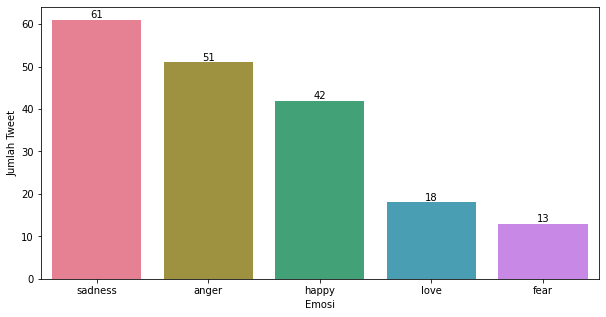

In [ ]:
figure, ax = plt.subplots(figsize=(10, 5))
number = [count for count in twitter_data["label"].value_counts()]
labels = list(twitter_data["label"].value_counts().index)
sns.barplot(x=labels, y=number, palette="husl")
ax.set_xlabel("Emosi")
ax.set_ylabel("Jumlah Tweet")
ax.bar_label(ax.containers[0])
plt.show()

_Menampilkan wordcloud tweet berlabel anger_

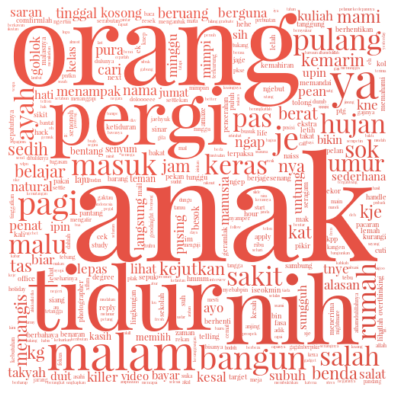

In [ ]:
anger_tweets = result[result.label == "anger"]
anger_tweets = anger_tweets.reset_index(drop=True)
list_of_words = ""
for word in anger_tweets.preprocessed:
    word = str(word)
    word = word.replace(keyword, "")
    word = word.split()
    list_of_words += " ".join(word) + " "
mask = np.array(Image.open("anger_mask.jpeg"))
font = "PlayfairDisplay-Regular.otf"
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, font_path=font, mask=mask).generate(list_of_words)
color = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7))
plt.imshow(wordcloud.recolor(color_func=color), interpolation="bilinear")
plt.axis("off")
plt.show()

_Menampilkan wordcloud tweet berlabel happy_

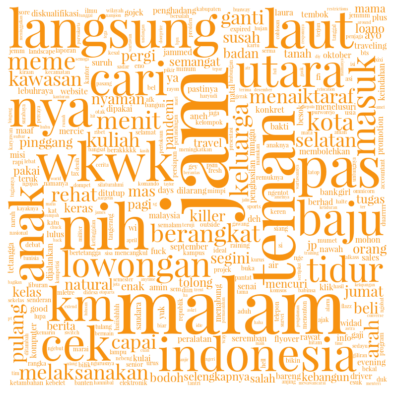

In [ ]:
happy_tweets = result[result.label == "happy"]
happy_tweets = happy_tweets.reset_index(drop=True)
list_of_words = ""
for word in happy_tweets.preprocessed:
    word = str(word)
    word = word.replace(keyword, "")
    word = word.split()
    list_of_words += " ".join(word) + " "
mask = np.array(Image.open("happy_mask.jpeg"))
font = "PlayfairDisplay-Regular.otf"
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, font_path=font, mask=mask).generate(list_of_words)
color = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7))
plt.imshow(wordcloud.recolor(color_func=color), interpolation="bilinear")
plt.axis("off")
plt.show()

_Menampilkan wordcloud tweet berlabel fear_

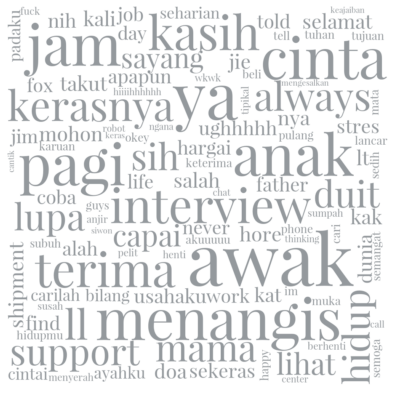

In [ ]:
fear_tweets = result[result.label == "fear"]
fear_tweets = fear_tweets.reset_index(drop=True)
list_of_words = ""
for word in fear_tweets.preprocessed:
    word = str(word)
    word = word.replace(keyword, "")
    word = word.split()
    list_of_words += " ".join(word) + " "
mask = np.array(Image.open("fear_mask.jpeg"))
font = "PlayfairDisplay-Regular.otf"
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, font_path=font, mask=mask).generate(list_of_words)
color = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7))
plt.imshow(wordcloud.recolor(color_func=color), interpolation="bilinear")
plt.axis("off")
plt.show()

_Menampilkan wordcloud tweet berlabel sadness_

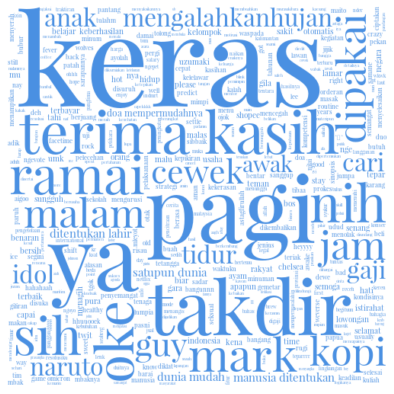

In [ ]:
sadness_tweets = result[result.label == "sadness"]
sadness_tweets = sadness_tweets.reset_index(drop=True)
list_of_words = ""
for word in sadness_tweets.preprocessed:
    word = str(word)
    word = word.replace(keyword, "")
    word = word.split()
    list_of_words += " ".join(word) + " "
mask = np.array(Image.open("sadness_mask.png"))
font = "PlayfairDisplay-Regular.otf"
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, font_path=font, mask=mask).generate(list_of_words)
color = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7))
plt.imshow(wordcloud.recolor(color_func=color), interpolation="bilinear")
plt.axis("off")
plt.show()

_Menampilkan wordcloud tweet berlabel love_

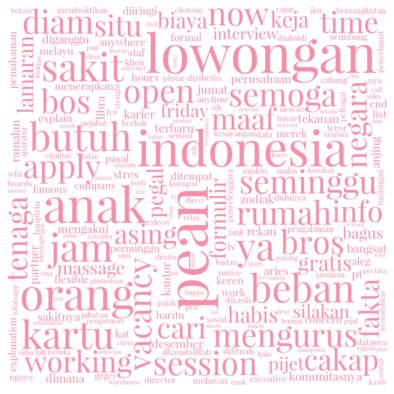

In [ ]:
love_tweets = result[result.label == "love"]
love_tweets = love_tweets.reset_index(drop=True)
list_of_words = ""
for word in love_tweets.preprocessed:
    word = str(word)
    word = word.replace(keyword, "")
    word = word.split()
    list_of_words += " ".join(word) + " "
mask = np.array(Image.open("love_mask.jpg"))
font = "PlayfairDisplay-Regular.otf"
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, font_path=font, mask=mask).generate(list_of_words)
color = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7))
plt.imshow(wordcloud.recolor(color_func=color), interpolation="bilinear")
plt.axis("off")
plt.show()